In [1]:
import torch.multiprocessing as mp
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import Adam
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as Func
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from torch.autograd import Variable
import torchvision.models as models
from facenet_pytorch import InceptionResnetV1


from collections import namedtuple
import pandas as pd
import glob
import random
import numpy as np
import collections
import copy
import os

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

## Dataset

In [3]:
class myImageDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, root_dir, transform=None, classes = None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return 7000

    def __getitem__(self, index):
        pic_class = index//500 + 1
        pic_idx =  int(index%14) + 1
        ori_img, target_img = self.get_img(pic_class, pic_idx), self.get_img(pic_class+1, pic_idx)
        label = torch.tensor(int(index//500))
        target_label = torch.tensor(int(index//500) + 1)
        if self.transform is not None:
            ori_img, target_img = self.transform(ori_img), self.transform(target_img)
        return ori_img, target_img, label, target_label
    
    def get_img(self, pic_class, pic_idx):
        pic_class =  '%03d'% pic_class
        if pic_idx < 11:    
            pic_idx = '%02d'% pic_idx
            pic_name = f'/{pic_class}/frontal/{pic_idx}.jpg'
        else:
            pic_idx -= 10
            pic_idx = '%02d'% pic_idx
            pic_name = f'/{pic_class}/profile/{pic_idx}.jpg'
        img_name = self.root_dir + pic_name
        img = Image.open(img_name).convert('RGB')
        return img

## Model

In [4]:
class BasicBlock(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel,out_channel, kernel_size=3,stride=1,padding=1, groups=1, bias=False, dilation=1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channel,out_channel, kernel_size=3,stride=1,padding=1, groups=1, bias=False, dilation=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x) :
        identity = x.detach_().clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

In [5]:
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

In [6]:
class encoder(nn.Module):
    def __init__(self, image_channels, z_dim, layer_count):
        super(encoder, self).__init__()
        self.layer_count = layer_count
        mul = 2
        out_dim = 32
        for i in range(layer_count):
            setattr(self, f'conv_{i}', nn.Conv2d(image_channels, out_dim, kernel_size= 4, stride=2 , padding= 1))
            setattr(self, f'batchnorm_2d_{i}', nn.BatchNorm2d(out_dim))
            image_channels = out_dim
            out_dim *= mul
    def forward(self, x):
        for i in range(self.layer_count):
            x = getattr(self,f'conv_{i}')(x)
            x = getattr(self,f'batchnorm_2d_{i}')(x)
            x = nn.LeakyReLU()(x)
        x = flatten(x)
        return x

In [7]:
class decoder(nn.Module):
    def __init__(self, z_dim, image_channels, layer_count, args):
        super(decoder, self).__init__()
        self.z_dim = z_dim
        self.layer_count = layer_count
        self.fc3 = nn.Linear(z_dim, 4*4*args.context_size)
        dev = 2
        out_dim = z_dim // 2
        for i in range(layer_count):
            if i == layer_count - 1:
                out_dim = 3
            setattr(self, f'conv_trans_{i}', nn.ConvTranspose2d(z_dim, out_dim, kernel_size= 4, stride=2 , padding= 1))
            setattr(self, f'de_batchnorm_2d_{i}', nn.BatchNorm2d(out_dim))
            z_dim //= dev
            out_dim //= dev
        self.args = args
        
            
    def forward(self, x):
        z = self.fc3(x)
        z = unflatten(z, self.args.context_size)
        for i in range(self.layer_count):
            z = getattr(self,f'conv_trans_{i}')(z)
            z = getattr(self,f'de_batchnorm_2d_{i}')(z)
            if i != self.layer_count - 1:
                z = nn.LeakyReLU()(z)
            else:
                z = nn.Tanh()(z)
        return z

In [8]:
class generator(nn.Module):
    def __init__(self, input_channel, out_channels, args, layer_count = 2):
        super(generator, self).__init__()
        self.layer_count = layer_count
        mul = 2
        out_dim = 32
        for i in range(layer_count):
            setattr(self, f'conv_{i}', nn.Conv2d(input_channel, out_dim, kernel_size= 4, stride=2 , padding= 1))
            setattr(self, f'batchnorm_2d_{i}', nn.BatchNorm2d(out_dim))
            input_channel = out_dim
            out_dim *= mul
        self.args = args
        self.se_block = SE_Block(input_channel)
        
        dev = 2
        inp_dim = input_channel
        out_dim = input_channel // 2
        
        for i in range(layer_count):
            if i == layer_count - 1:
                out_dim = 3
            setattr(self, f'conv_trans_{i}', nn.ConvTranspose2d(inp_dim, out_dim, kernel_size= 4, stride=2 , padding= 1))
            setattr(self, f'de_batchnorm_2d_{i}', nn.BatchNorm2d(out_dim))
            inp_dim //= dev
            out_dim //= dev
        
    def forward(self, x):
        for i in range(self.layer_count):
            x = getattr(self,f'conv_{i}')(x)
            x = getattr(self,f'batchnorm_2d_{i}')(x)
            x = nn.LeakyReLU()(x)
        x = self.se_block(x)

        for i in range(self.layer_count):
            x = getattr(self,f'conv_trans_{i}')(x)
            x = getattr(self,f'de_batchnorm_2d_{i}')(x)
            if i != self.layer_count - 1:
                x = nn.LeakyReLU()(x)
            else:
                x = nn.Tanh()(x)
        return x

In [9]:
# class generator(nn.Module):
#     def __init__(self, z_dim, image_channels, layer_count, args):
#         super(generator, self).__init__()
#         self.z_dim = z_dim
#         self.layer_count = layer_count
#         self.fc3 = nn.Linear(z_dim, 4*4*z_dim)
#         dev = 2
#         out_dim = z_dim // 2
#         for i in range(layer_count):
#             if i == layer_count - 1:
#                 out_dim = 3
#             setattr(self, f'conv_trans_{i}', nn.ConvTranspose2d(z_dim, out_dim, kernel_size= 4, stride=2 , padding= 1))
#             setattr(self, f'de_batchnorm_2d_{i}', nn.BatchNorm2d(out_dim))
#             z_dim //= dev
#             out_dim //= dev
#         self.args = args
        
            
#     def forward(self, x):
#         z = self.fc3(x)
#         z = unflatten(z, self.args.context_size)
#         for i in range(self.layer_count):
#             z = getattr(self,f'conv_trans_{i}')(z)
#             z = getattr(self,f'de_batchnorm_2d_{i}')(z)
#             if i != self.layer_count - 1:
#                 z = nn.LeakyReLU()(z)
#             else:
#                 z = nn.Tanh()(z)
#         return z

In [16]:
class VAE(nn.Module):
    def __init__(self, args, image_channels=3, z_dim=256, layer_count = 4, is_g1 = False):
        super(VAE, self).__init__()
        self.layer_count = layer_count
        self.gan_mu = nn.Linear(4*4*256, z_dim)
        self.gan_var = nn.Linear(4*4*256, z_dim)
        self.encoder = encoder(image_channels, z_dim, layer_count)
        self.decoder = decoder(z_dim, args.channel_size, layer_count, args)
#         self.generator = generator(2*z_dim, image_channels, layer_count,args)
        self.generator = generator(2*image_channels, image_channels, args)
        self.basic_block = BasicBlock(image_channels,image_channels)
        self.args = args
        self.image_channels = image_channels
        self.is_g1 = is_g1
        self.mse_loss = nn.MSELoss()
#         self.se_block = SE_Block()
        
    def weight_init(self, mean, std):
        for m in self._modules:
            self.normal_init(self._modules[m], mean, std)

    def normal_init(self, m, mean, std):
        if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(mean, std)
            m.bias.data.zero_()
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp.to(self.args.device)    
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.gan_mu(h).sigmoid(), self.gan_var(h)
        logvar = Func.log_softmax(logvar, dim = -1)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, ori_x, target_x):
        resi_x = self.basic_block(target_x)
        attn_x = self.attn(resi_x).to(self.args.device)
        enc_x = self.encoder(attn_x)
        z, mu, logvar = self.bottleneck(enc_x)
        recon_tar_x = self.decoder(z)
        vae_loss_1, MSE, KLD  = self.loss_fn(recon_tar_x, target_x, mu, logvar)
        
        if not self.is_g1:
            return recon_tar_x, None        

#         ori_enc_x = self.encoder(ori_x)
#         ori_z, ori_mu, ori_logvar = self.bottleneck(ori_enc_x)
#         recon_ori_x = self.decoder(ori_z)
#         vae_loss_2, MSE, KLD  = self.loss_fn(recon_ori_x, ori_x, ori_mu, ori_logvar)
#         concat_feat = torch.cat((ori_z, z), dim = 1)
        concat_feat = torch.cat((ori_x, recon_tar_x),dim = 1)
        recon_x = self.generator(concat_feat)
        recon_loss = self.mse_loss(recon_x, ori_x) + vae_loss_1
        return recon_x ,recon_loss
    
    def decode(self, x):
        return self.decoder(x)
    
    def attn(self, inputs):
        N, C, H, W = self.args.batch_size, self.image_channels, self.args.input_size, self.args.input_size
        patches = Func.unfold(inputs, (H//2, W//2), stride = 64).reshape(N,C,-1)
        m_inputs = inputs.view(N,C,-1).permute(0,2,1)
        weight = torch.bmm(m_inputs, patches)
        resi_inputs = torch.bmm(weight, patches.reshape(N,-1,C))
        inputs = torch.add(inputs, resi_inputs.reshape(N,C,H,W))
        return inputs
    
    def loss_fn(self, recon_x, x , mu, logvar):
        MSE = Func.mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp()) * args.kld_weight 
        return MSE + KLD, MSE, KLD 

In [17]:
class Discriminator(nn.Module):
    """docstring for ClassName"""
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = models.resnet18(pretrained=True)
        self.classifier = nn.Sequential(nn.Linear(1000,200),nn.BatchNorm1d(200),nn.ReLU(),nn.Linear(200,1),nn.Sigmoid())
    def forward(self,input):
        feat = self.feature_extractor(input)
        pred = self.classifier(feat)
        return pred
    def get_feature(self, x):
        return self.feature_extractor(x)

class Aaan(nn.Module):
    """docstring for ClassName"""
    def __init__(self, args, image_channels=3, z_dim=256, layer_count = 4):
        super(Aaan, self).__init__()
        self.l1_loss = nn.L1Loss()
        self.loss = nn.MSELoss()
        self.pair_loss = nn.PairwiseDistance()
        self.z_dim = z_dim
        self.vae = VAE(args, z_dim = z_dim, is_g1 = True)
#         self.G1 =  VAE(args, z_dim = z_dim, is_g = True)
        self.G2 =  VAE(args, z_dim = z_dim)
        self.Identity_Discriminator = Discriminator()
        self.Sample_Discriminator = Discriminator()
        self.image_channels = image_channels
        self.args = args   

    def forward(self, origin_face, target_face, train_d):
        result = namedtuple('result', ["construct_image","adv_g_loss","adv_d_loss","rec_loss","cos_loss"])
        adv_g_loss, adv_d_loss, rec_loss, cos_loss = 0, 0, 0, 0
        construct, vae_loss  = self.vae(origin_face, target_face)
#         _, _, construct, _ = self.G1(concat_feat)
        back_construct, _ = self.G2(None, construct.detach())
        rec_loss += vae_loss
#         rec_loss += self.loss(origin_face, back_construct) 
        cos_loss += self.cos_loss(target_face, construct)
#         reconstruct_loss = self.l1_loss(origin_face, back_construct) + self.loss(construct, origin_face) 
        if train_d == 1:
            Identity_dloss = self.calculate_identity_loss(construct,target_face)
            Sample_dloss = self.calculate_sample_loss(construct,origin_face)
            adv_d_loss += Identity_dloss + Sample_dloss
        else:
            identity_pred = self.Identity_Discriminator(construct)
            real_pred = self.Sample_Discriminator(construct)
            labels = torch.ones(identity_pred.size()).to(self.args.device)
            adv_g_loss += self.loss(identity_pred,labels) + self.loss(real_pred,labels)
        output = result(construct, adv_g_loss, adv_d_loss,  10 * rec_loss,  10 *cos_loss)
        return output

    def calculate_identity_loss(self,construct,target_face):
        origin_pred = self.Identity_Discriminator(construct)
        target_pred = self.Identity_Discriminator(target_face)
        origin_label = torch.zeros(origin_pred.size()).to(self.args.device)
        target_label = torch.ones(target_pred.size()).to(self.args.device)
        ori_loss = self.loss(origin_pred,origin_label)
        target_loss = self.loss(target_pred,target_label)
        Identity_dloss = (ori_loss + target_loss)
#         return 0
        return Identity_dloss
    def calculate_sample_loss(self,construct,origin_face):
        construct_pred = self.Sample_Discriminator(construct)
        origin_pred = self.Sample_Discriminator(origin_face)
        construct_label = torch.zeros(construct_pred.size()).to(self.args.device)
        origin_label = torch.ones(origin_pred.size()).to(self.args.device)
        fake_loss = self.loss(construct_pred,construct_label)
        ori_loss = self.loss(origin_pred,origin_label)
        Identity_dloss = (fake_loss + ori_loss)
        return Identity_dloss
    def cos_loss(self, x1, x2):
        fea_1, fea_2 = self.Identity_Discriminator.get_feature(x1), self.Identity_Discriminator.get_feature(x2)
#         return -Func.cosine_similarity(x1, x2).abs().mean()
        return (1 - Func.cosine_similarity(fea_1, fea_2, 1, 1e-8)).sum()
#         return self.pair_loss(x1,x2).mean()
    
    def generate_adv(self, origin_face, target_face):
        construct, vae_loss  = self.vae(origin_face, target_face)
        return construct

## Training

In [18]:
def flatten(x):
    return x.view(x.size(0), -1)
def unflatten(x, size):
    return x.view(x.size(0), -1, 4, 4)

def get_optimizer(model, lr):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = 1e-3,lr = lr)
    return optimizer

In [19]:
class Args():
    def __init__(self):
        self.epoch = 100
        self.batch_size = 64
        self.lr = 1e-3
        self.gpu = torch.cuda.is_available()
        self.device = 1
        self.input_size = 64
        self.channel_size = 3
        self.context_size = 128
        self.kld_weight = 1e-6
        self.alter_step = 20

In [20]:
args = Args()

root_dir = 'dataset/cfp-dataset/Data/Images'
text_file = 'dataset/cfp-dataset/Data/list_name.txt'
classes = []
with open (text_file, 'r') as f:
    for i in f.read().split('\n'):
        classes.append(i)

mean, std = [0.5], [0.5]
transform = transforms.Compose([
        transforms.Resize((args.input_size, args.input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
        ])
dataset = myImageDataset(root_dir, transform, classes)

trainloader = DataLoader(dataset, batch_size = args.batch_size, drop_last = True, shuffle= True, worker_init_fn=0, )
a3n = Aaan(args, z_dim = args.context_size)
a3n.train()
optimizer = get_optimizer(a3n, args.lr)
if args.gpu:
    a3n = a3n.to(args.device)

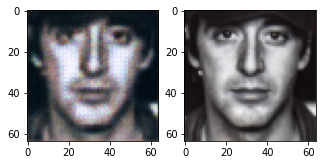

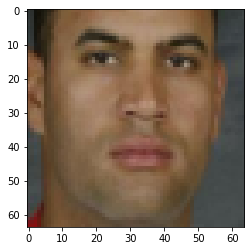

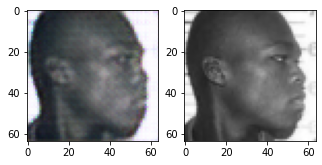

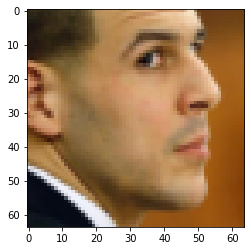

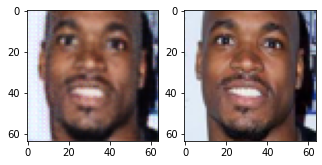

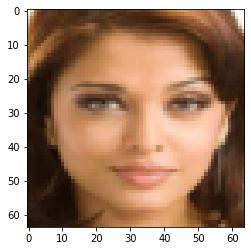

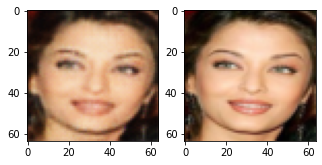

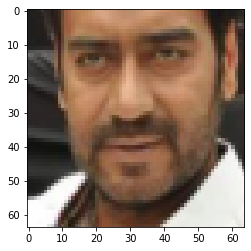

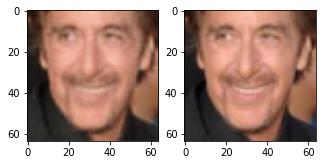

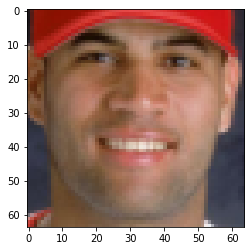

KeyboardInterrupt: 

In [21]:
mode = {0:'g', 1:'d'}
train_d = 1
for epo in range(args.epoch):
    index = 0
    total_loss = 0
    total = 0
    a3n.train()
    for param in trainloader:        
        if args.gpu:
            ori_img, target_img, label, target_label = [i.to(args.device) for i in param]
        if index % args.alter_step <= 10:
            train_d = 1
        else:
            train_d = 0
        output = a3n(ori_img, target_img, train_d)
        if epo > 5:
            loss =  sum(output[1:5] )
        else:
            loss =  output[3]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total += len(ori_img)
        total_loss += loss.detach_().cpu()
        print(f'epoch : {epo}, iteration: {index + 1} / {len(trainloader)},total_loss: {total_loss / total}, adv_g_loss: {output[1]}, adv_d_loss: {output[2]},recon_loss:{output[3]}, cos_loss: {output[4]}', end = '\r')
        index += 1
        
    if (epo + 1) % 2 == 0:
        a3n.eval()
        for param in trainloader:
            if args.gpu:
                ori_img, target_img, label, target_label = [i.to(args.device) for i in param]
            with torch.no_grad():
                recon_images = a3n.generate_adv(ori_img, target_img)
        #     recon_images, loss = vae(img)
            break
        rev_tran = transforms.Compose([
            transforms.Normalize(mean=(-1.0,-1.0,-1.0),std = (2.0,2.0,2.0)),
            transforms.ToPILImage()
        ])
        fig = plt.figure(figsize = (8,4))
        fig.add_subplot(1,3,1)
        plt.imshow(rev_tran(recon_images[0].cpu()))
        fig.add_subplot(1,3,2)
        plt.imshow(rev_tran(ori_img[0].cpu()))
        plt.show()
        fig.add_subplot(1,3,3)
        plt.imshow(rev_tran(target_img[0].cpu()))
        plt.show()

In [ ]:
a3n.eval()
for param in trainloader:
    if args.gpu:
        ori_img, target_img, label, target_label = [i.to(args.device) for i in param]
    with torch.no_grad():
        recon_images = a3n.generate_adv(ori_img, tazrget_img)
#     recon_images, loss = vae(img)
    break
rev_tran = transforms.Compose([
    transforms.Normalize(mean=(-1.0,-1.0,-1.0),std = (2.0,2.0,2.0)),
    transforms.ToPILImage()
])
fig = plt.figure(figsize = (8,4))
fig.add_subplot(1,3,1)
plt.imshow(rev_tran(recon_images[0].cpu()))
fig.add_subplot(1,3,2)
plt.imshow(rev_tran(ori_img[0].cpu()))
plt.show()
fig.add_subplot(1,3,3)
plt.imshow(rev_tran(target_img[0].cpu()))
plt.show()